Correlation matrix between outputs:
[[1.         0.91239745 0.58625515]
 [0.91239745 1.         0.80718217]
 [0.58625515 0.80718217 1.        ]]

Mean Squared Error (MSE) of each model:
Native Multi-Output RandomForestRegressor: 0.4197
MultiOutputRegressor with RandomForestRegressor: 0.4127
RegressorChain with RandomForestRegressor: 0.4665


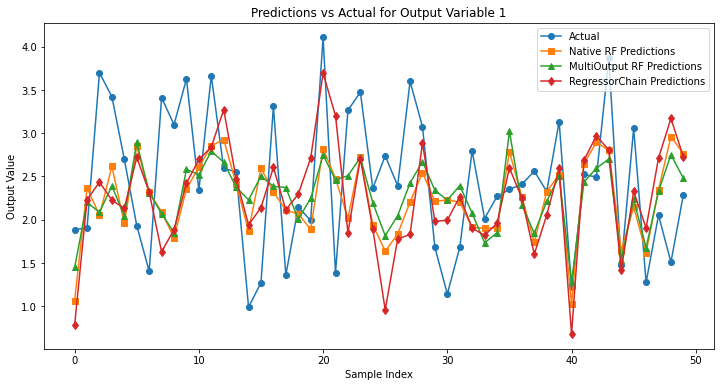

In [1]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.multioutput import MultiOutputRegressor, RegressorChain
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

# Suppress warnings
import warnings
warnings.filterwarnings('ignore')

# 1. Generate Synthetic Dataset
def generate_correlated_outputs_dataset(n_samples=1000, n_features=10, n_outputs=3, random_state=0):
    np.random.seed(random_state)
    # Generate random features
    X = np.random.rand(n_samples, n_features)
    # Generate latent variables
    latent = np.random.rand(n_samples, 1)
    # Generate outputs with shared latent variable to induce correlation
    Y = np.zeros((n_samples, n_outputs))
    for i in range(n_outputs):
        Y[:, i] = (
            np.sin(X[:, 0] * (i+1)) +
            np.log1p(X[:, 1]) * (i+1) +
            latent[:, 0] * (n_outputs - i) +  # Shared latent variable
            np.random.normal(0, 0.1, n_samples)  # Small noise
        )
    return X, Y

# Generate the dataset
X, Y = generate_correlated_outputs_dataset()

# Check correlations between outputs
corr_matrix = np.corrcoef(Y.T)
print("Correlation matrix between outputs:")
print(corr_matrix)

# Split into training and testing sets
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

# 2. Define Models
# a. Native Multi-Output RandomForestRegressor
rf_native = RandomForestRegressor(n_estimators=100, random_state=0)

# b. MultiOutputRegressor with RandomForestRegressor
rf_base = RandomForestRegressor(n_estimators=100, random_state=0)
rf_multioutput = MultiOutputRegressor(rf_base)

# c. RegressorChain with RandomForestRegressor
rf_chain = RegressorChain(base_estimator=RandomForestRegressor(n_estimators=100, random_state=0), order='random', random_state=0)

# 3. Train Models
# a. Native Multi-Output
rf_native.fit(X_train, Y_train)

# b. MultiOutputRegressor
rf_multioutput.fit(X_train, Y_train)

# c. RegressorChain
rf_chain.fit(X_train, Y_train)

# 4. Make Predictions
Y_pred_native = rf_native.predict(X_test)
Y_pred_multioutput = rf_multioutput.predict(X_test)
Y_pred_chain = rf_chain.predict(X_test)

# 5. Evaluate Models
mse_native = mean_squared_error(Y_test, Y_pred_native)
mse_multioutput = mean_squared_error(Y_test, Y_pred_multioutput)
mse_chain = mean_squared_error(Y_test, Y_pred_chain)

print("\nMean Squared Error (MSE) of each model:")
print(f"Native Multi-Output RandomForestRegressor: {mse_native:.4f}")
print(f"MultiOutputRegressor with RandomForestRegressor: {mse_multioutput:.4f}")
print(f"RegressorChain with RandomForestRegressor: {mse_chain:.4f}")

# 6. Visualize Predictions vs Actual for one of the outputs
output_index = 0  # Index of the output variable to visualize

plt.figure(figsize=(12, 6))
plt.plot(Y_test[:50, output_index], 'o-', label='Actual')
plt.plot(Y_pred_native[:50, output_index], 's-', label='Native RF Predictions')
plt.plot(Y_pred_multioutput[:50, output_index], '^-', label='MultiOutput RF Predictions')
plt.plot(Y_pred_chain[:50, output_index], 'd-', label='RegressorChain Predictions')
plt.title(f'Predictions vs Actual for Output Variable {output_index + 1}')
plt.xlabel('Sample Index')
plt.ylabel('Output Value')
plt.legend()
plt.show()
